In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# set font size for axises
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

In [40]:
# fetch data and store them into dictionary
# store directory_name/dataframe pairs
train_raw, train_label, test_raw, test_label = {}, {}, {}, {}
    
dataset_dir = 'HMP_Dataset/'
for directory in os.listdir(dataset_dir):
    # skip model dataset
    if ('MODEL' in directory):
        continue     
    # create sub_directory
    sub_directory = os.path.join(dataset_dir, directory)
    if os.path.isdir(sub_directory):
        # get all files under the directory
        data, filenames = [], []
        for filename in os.listdir(sub_directory):
            # create path
            path = os.path.join(sub_directory, filename)    
            # create data, columns are seperated by ' '
            current_df = np.loadtxt(path, delimiter=' ')
            data.append(current_df)
            filenames.append((directory, filename))
        x_train, x_test, y_train, y_test = train_test_split(data, filenames,test_size = 0.2)
        train_raw[directory] = x_train             # store directory_name/dataframe pairs
        train_label[directory] = y_train
        test_raw[directory] = x_test
        test_label[directory] = y_test

Build a classifier that classifies sequences into one of the 14 activities provided.
To make features, you should **vector quantize**, then use a **histogram
of cluster centers** (as described in the subsection; this gives a pretty explicit
set of steps to follow). You will find it helpful to use **hierarchical
k-means** to vector quantize. You may use whatever **multi-class classifier**
you wish, though I’d start with R’s decision forest, because it’s easy to
use and effective. You should report (a) the **total error rate** and (b) the
**class confusion matrix** of your classifier

In [59]:
# split data with the segment length provided
def split_data(data, label, seg_length):
    segs, segs_labels = [], []
    for activity in data:
        rawdata_list = data[activity]
        datalabel_list = label[activity]
        for i in range (len(rawdata_list)):
            tempdata = rawdata_list[i]
            segment_split = np.arange(seg_length, len(tempdata),seg_length)
            segment_result = np.split(tempdata,segment_split)
            if(segment_result[-1].shape[0] != seg_length):
                segment_result.pop()
            segs.extend(segment_result)
            segs_labels.extend([datalabel_list[i]] * len(segment_result))
    return segs, segs_labels

# vector quantize
def vector_quant(data, label, cluster_size, codebook):
    vq_result = np.zeros(len(data))
    for i in range(len(data)):
        current_min = np.inf
        for j in range(cluster_size):
            tmp = np.linalg.norm(data[i] - codebook[j])
            if (tmp < current_min):
                current_min = tmp
                vq_result[i] = j
    
    code = vq_result.astype(int)
    histogram = np.zeros((len(set(label)), cluster_size))
    label_folder, firstFolder, row = [label[0][0]], label[0][1], 0
    for i in range (len(label)):
        if(label[i][1] == firstFolder):
            seg_fall_cluster = code[i]
        else:
            row = row + 1;
            label_folder.append(label[i][0])  
            seg_fall_cluster = code[i]
            firstFolder = label[i][1]
        histogram[row][seg_fall_cluster] += 1
    
    return histogram, label_folder

# run forest
def runForest(tr_x, tr_y, te_x, te_y, seg_length, cluster_size):
    train_segs, train_label = split_data(tr_x, tr_y, seg_length)
    test_segs, test_label = split_data(te_x, te_y, seg_length)
    
    train_segs = np.reshape(train_segs, (len(train_segs), seg_length * 3))
    test_segs = np.reshape(test_segs, (len(test_segs), seg_length * 3))
    codebook, unused = kmeans(train_segs, cluster_size)
    train_hist, train_folder_label = vector_quant(train_segs, train_label, cluster_size, codebook)
    test_hist, test_folder_label = vector_quant(test_segs, test_label, cluster_size, codebook)
    
    forestTree = RandomForestClassifier(max_depth=None, n_estimators=cluster_size).fit(train_hist, train_folder_label)
    prediction = forestTree.predict(test_hist)
    #print(confusion_matrix(test_folder_label, prediction))
    plot_histogram(train_hist)
    return pd.crosstab(pd.Series(prediction, name="prediction"), pd.Series(test_folder_label, name="actual"))#accuracy_score(test_folder_label, prediction) 

# plot histogram
def plot_histogram(data):
    fig=plt.figure(figsize=(40, 10))
    for i in range(14):
        s = sum(data[i])
        for j in range(len(data[i])):
            fig.add_subplot(2, 7, i + 1)
            plt.vlines(j, 0, data[i][j] / s)
    plt.show()

# display a list of seg_length and clusters
def display_table(train, test, seg_length, cluster_size):
    table_list = []
    for seg in seg_length:
        for cluster in cluster_size:
            acc = runForest(train[0], train[1], test[0], test[1], seg, cluster)
            table_list.append([str(seg), '0%' , str(cluster), 'Decision Tree', str(acc)])
    return pd.DataFrame(table_list, columns=['Segment_length','Overlap (0-X%)','K-value','Classifier','Accuracy'])

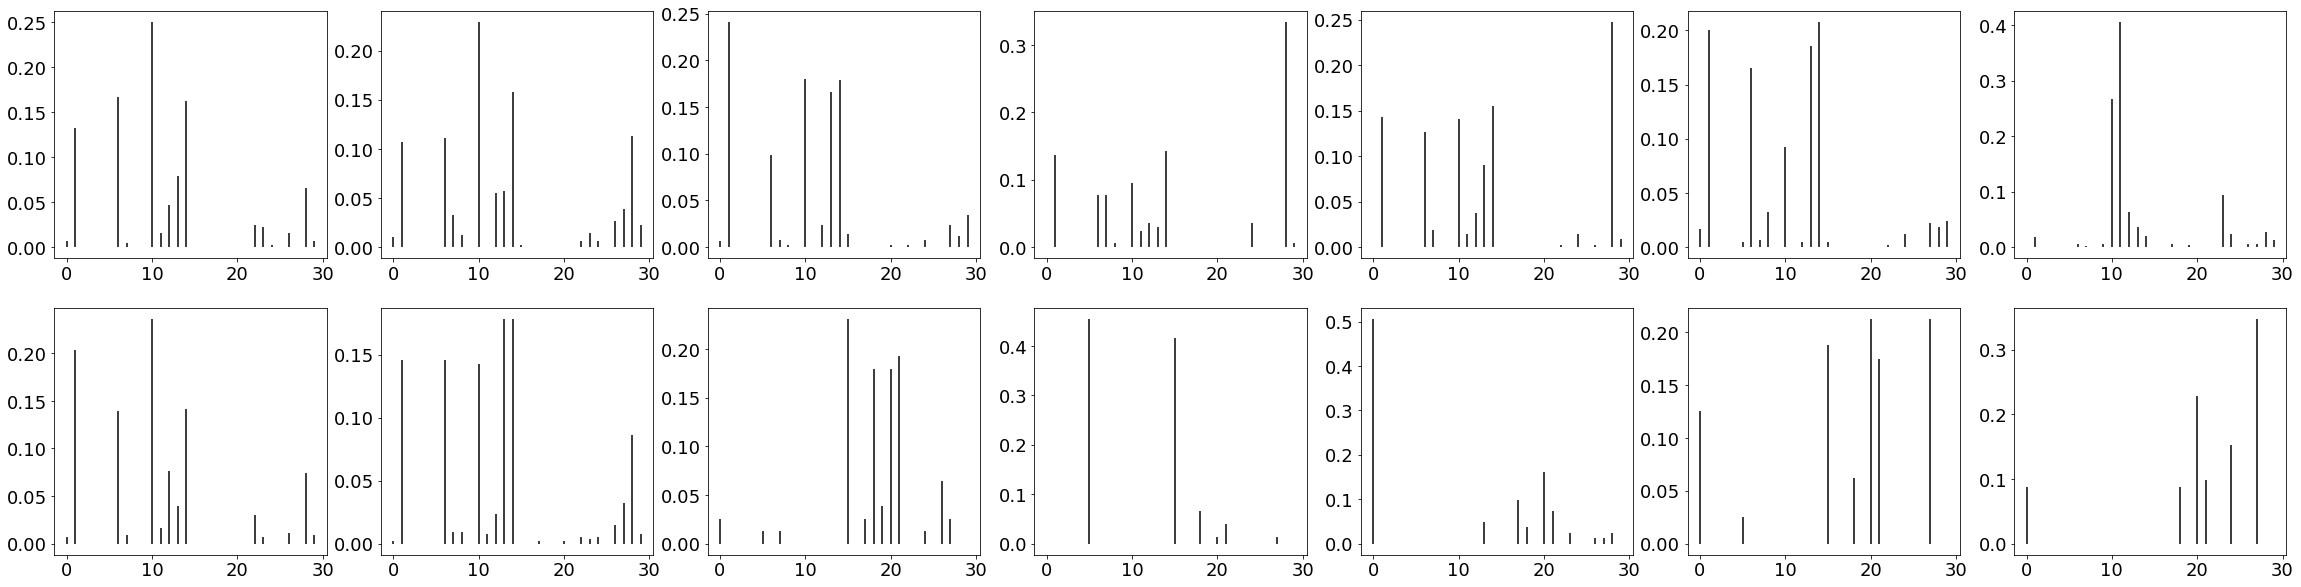

In [60]:
k = runForest(train_raw, train_label, test_raw,test_label,5, 30)

Now see if you can improve your classifier by (a) modifying the **number
of cluster centers** in your hierarchical k-means and (b) modifying the **size
of the fixed length samples** that you use.

[[ 2  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0 17  0  1  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  8  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 19  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  5  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  0  1 15  3  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  4 16  0  0]
 [ 0  0  1  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  1  0  0  0  0  0  0  0  1  0 16]]


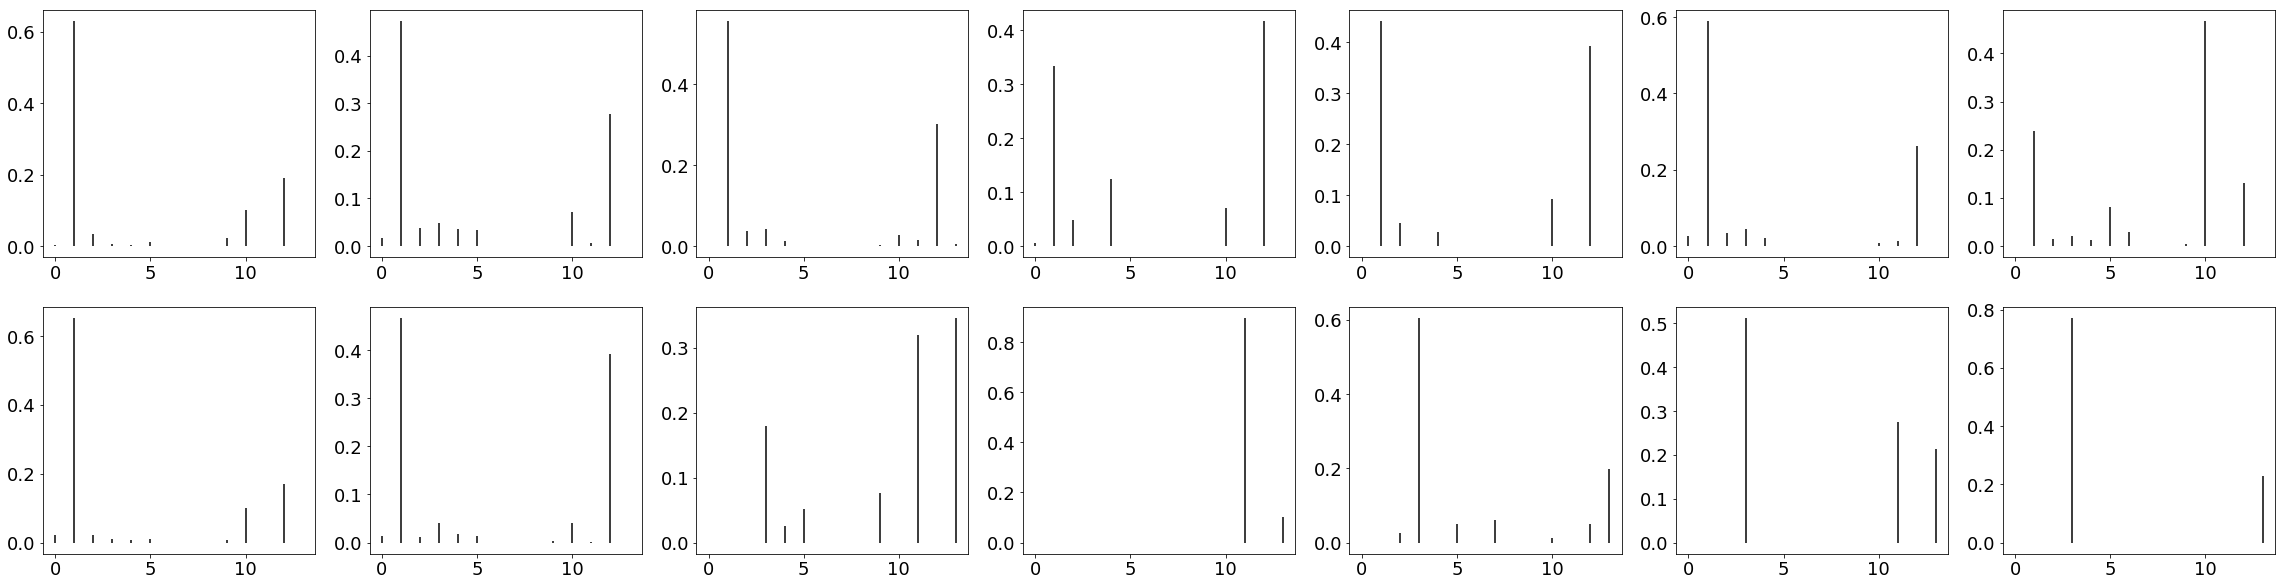

[[ 2  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  8  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5 16  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  1  0 17]]


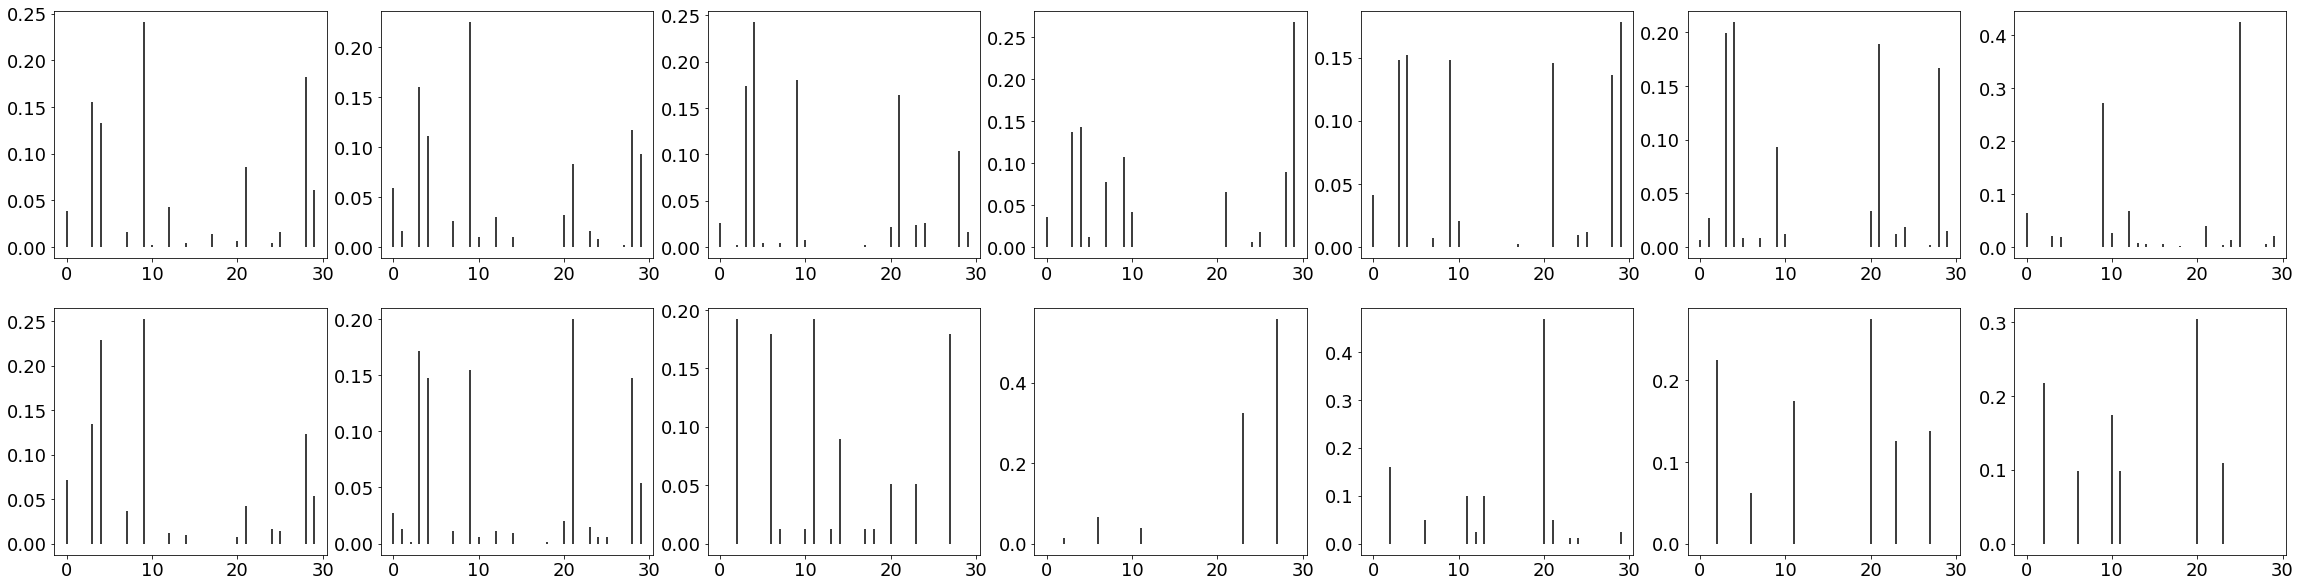

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  1  0  0  0]
 [ 0  0  0  0  2  0  0  2  0  1 12  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3 18  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  1  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  1  0 15]]


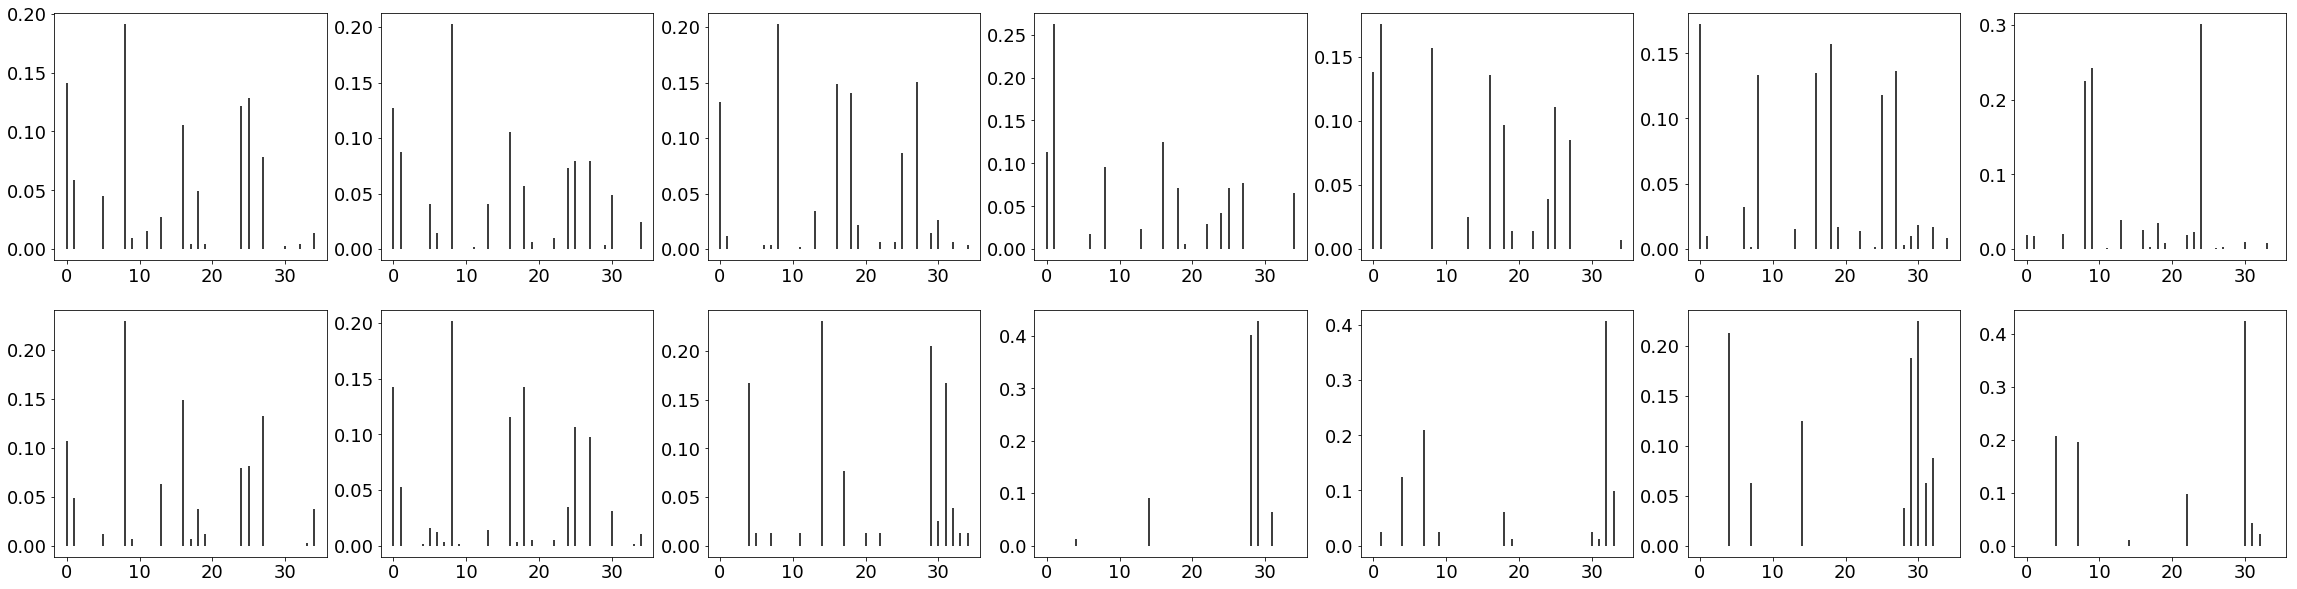

[[ 2  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 19  0  1  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  2  0  3  0  0  0]
 [ 0  0  1  0  0  0  0  3  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 15  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7 14  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  0  1  0]
 [ 0  4  0  0  0  0  0  0  0  0  1  0  0 15]]


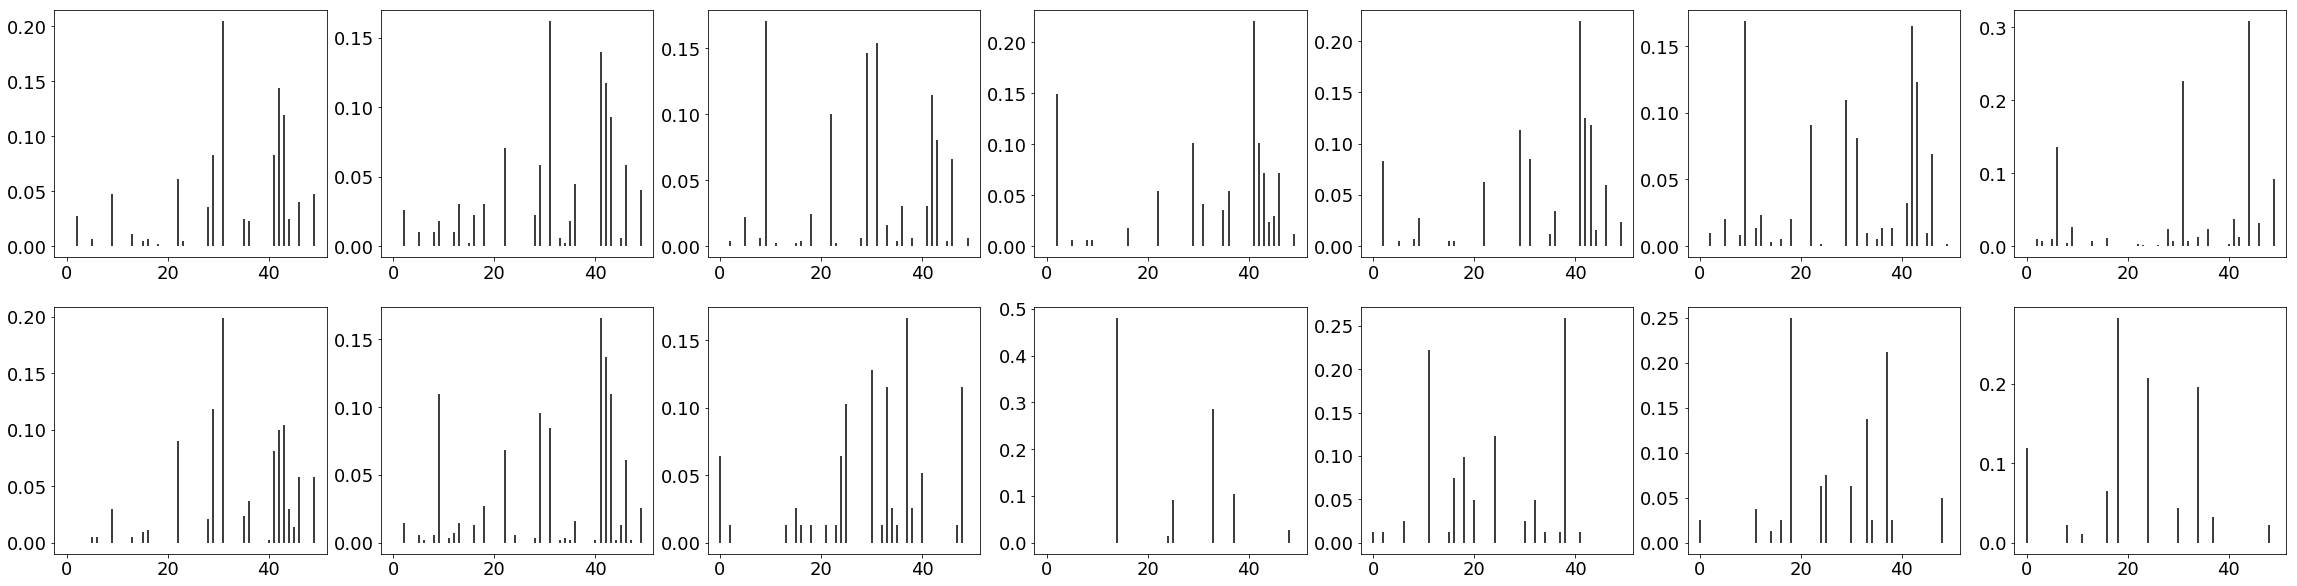

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  2  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  5  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  2  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 19  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0 13  1  1  2  2  0  0]
 [ 0  1  0  0  0  0  0  2  0  0  1  2  0  0]
 [ 0  0  0  0  1  0  0  0  0 18  1  0  0  0]
 [ 0  1  0  0  1  0  0  1  0  1 11  5  0  0]
 [ 0  0  0  1  0  0  0  3  0  0  3 14  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  1  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  1  0 17]]


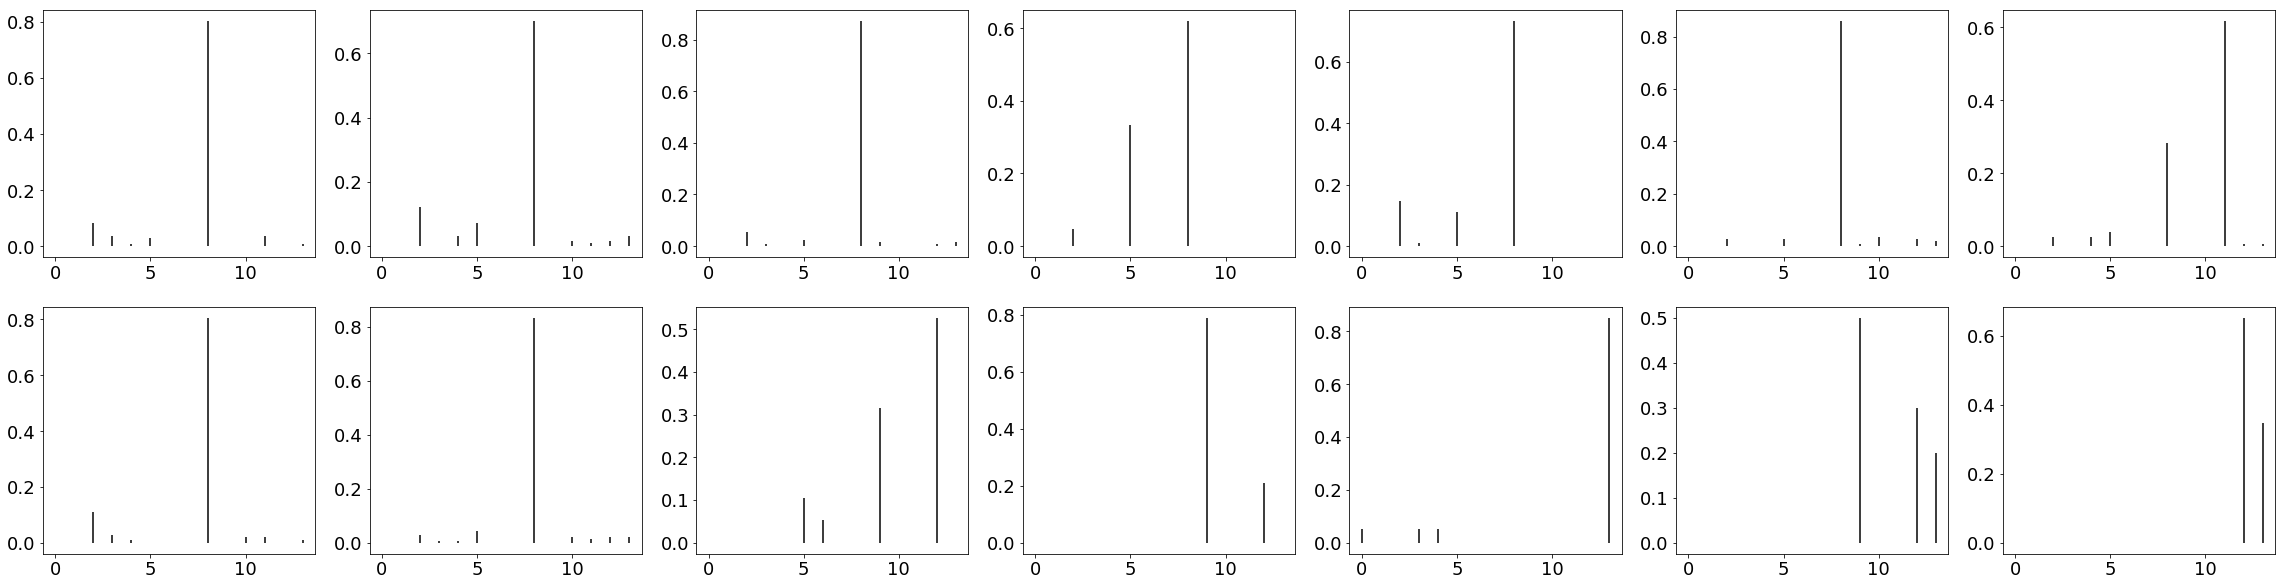

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  1  0  0  1  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  5  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0 15  0  0  1  3  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  1  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  1 13  4  0  0]
 [ 0  2  0  0  0  0  0  3  0  0  1 15  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  0  1  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  1  0 17]]


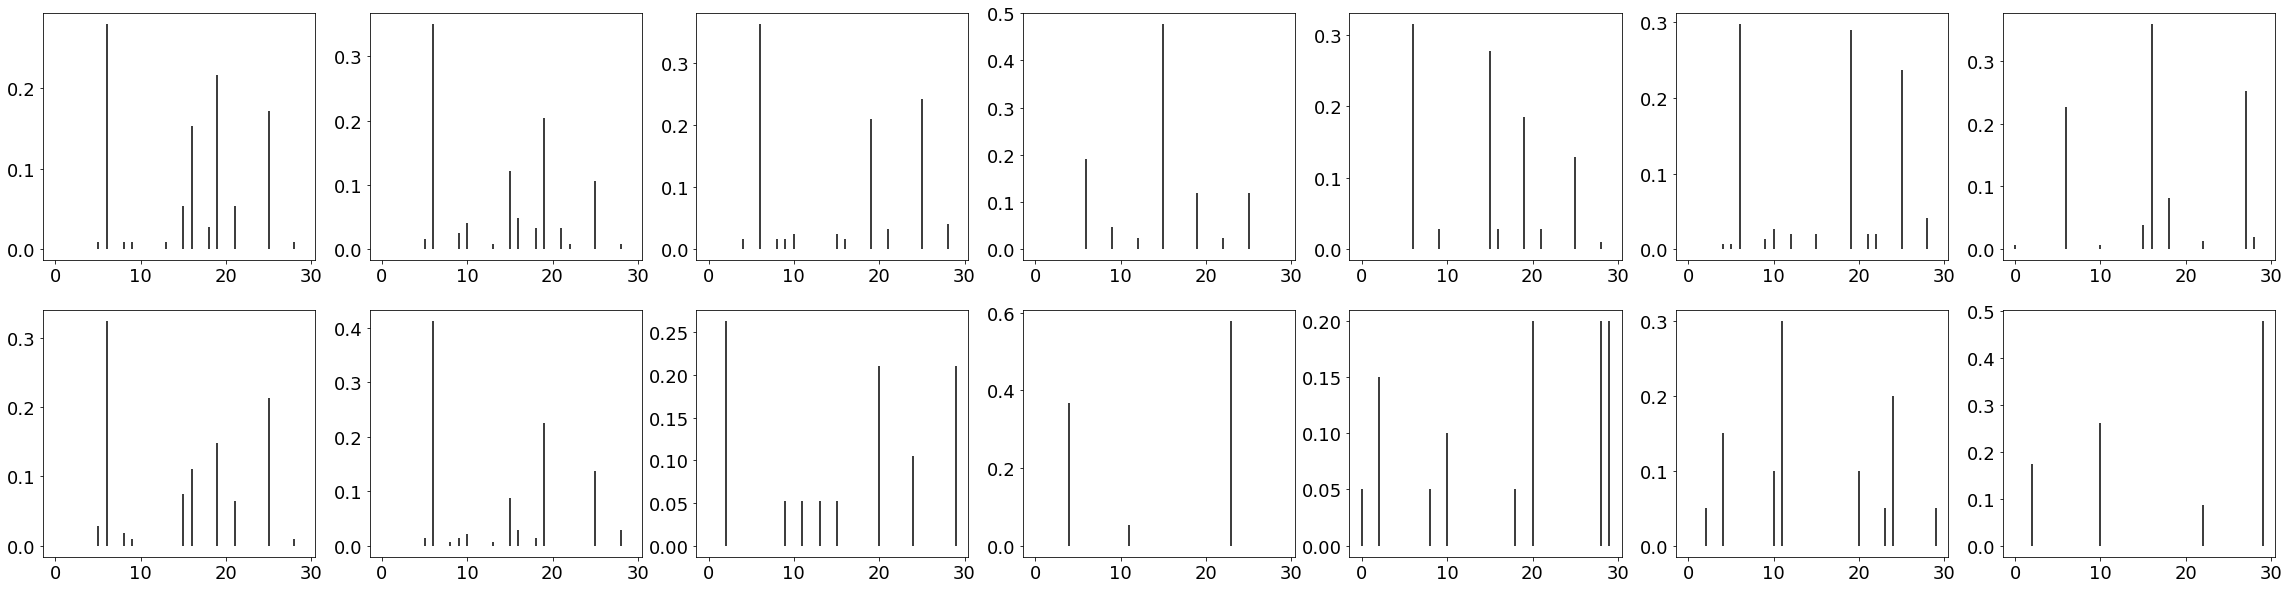

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  1  1  0  0  0  0  0  1  0  0  1]
 [ 0  0  6  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0 18  1  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  2  0  1  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  1  0  0  1  0  0 12  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  8 13  0  0]
 [ 0  0  0  0  1  0  0  0  0  1  0  0  1  0]
 [ 0  2  0  2  0  0  0  0  0  0  0  1  0 15]]


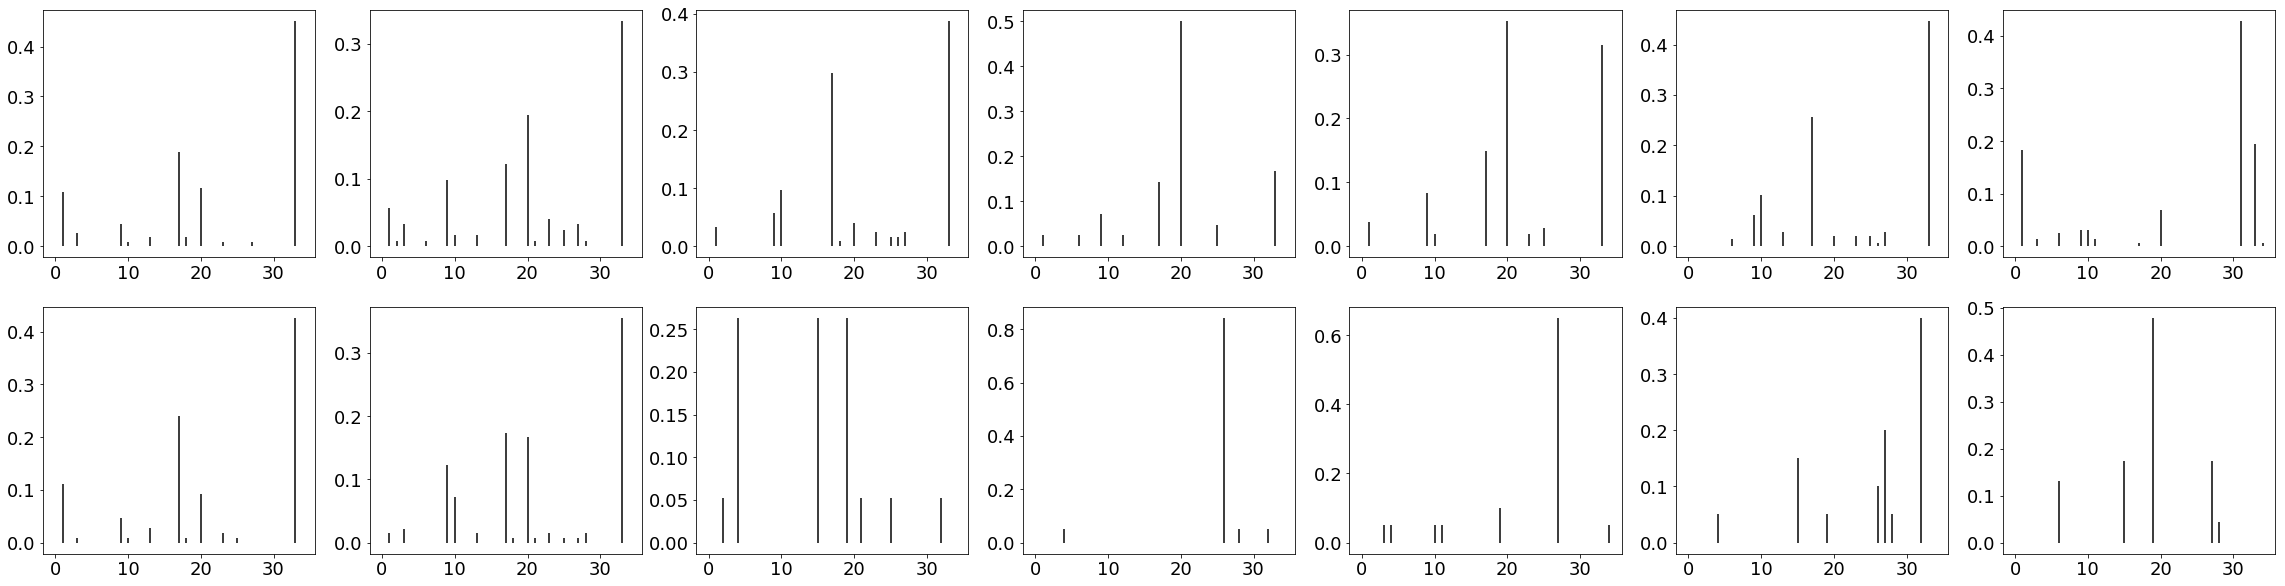

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  3  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  1  1  3  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0 14  5  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  3 17  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  1  0  0  0]
 [ 0  3  0  1  0  0  0  0  0  0  1  0  0 15]]


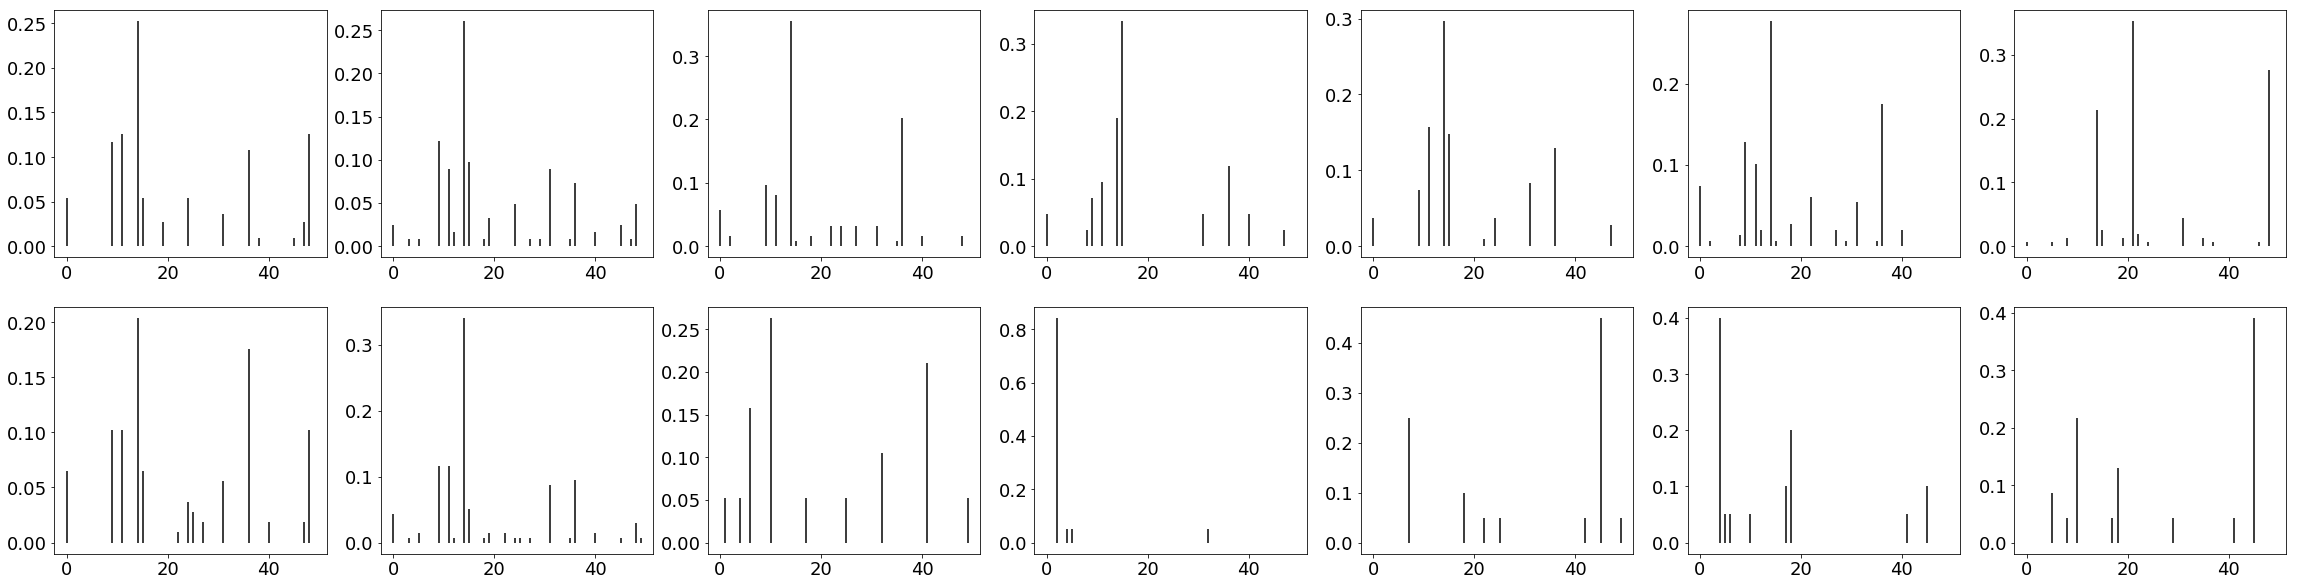

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  1  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  5  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  3  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0 19  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0 15  1  1  1  1  0  0]
 [ 0  0  0  0  1  0  0  2  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1 15  3  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  3 17  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  1  0  0 17]]


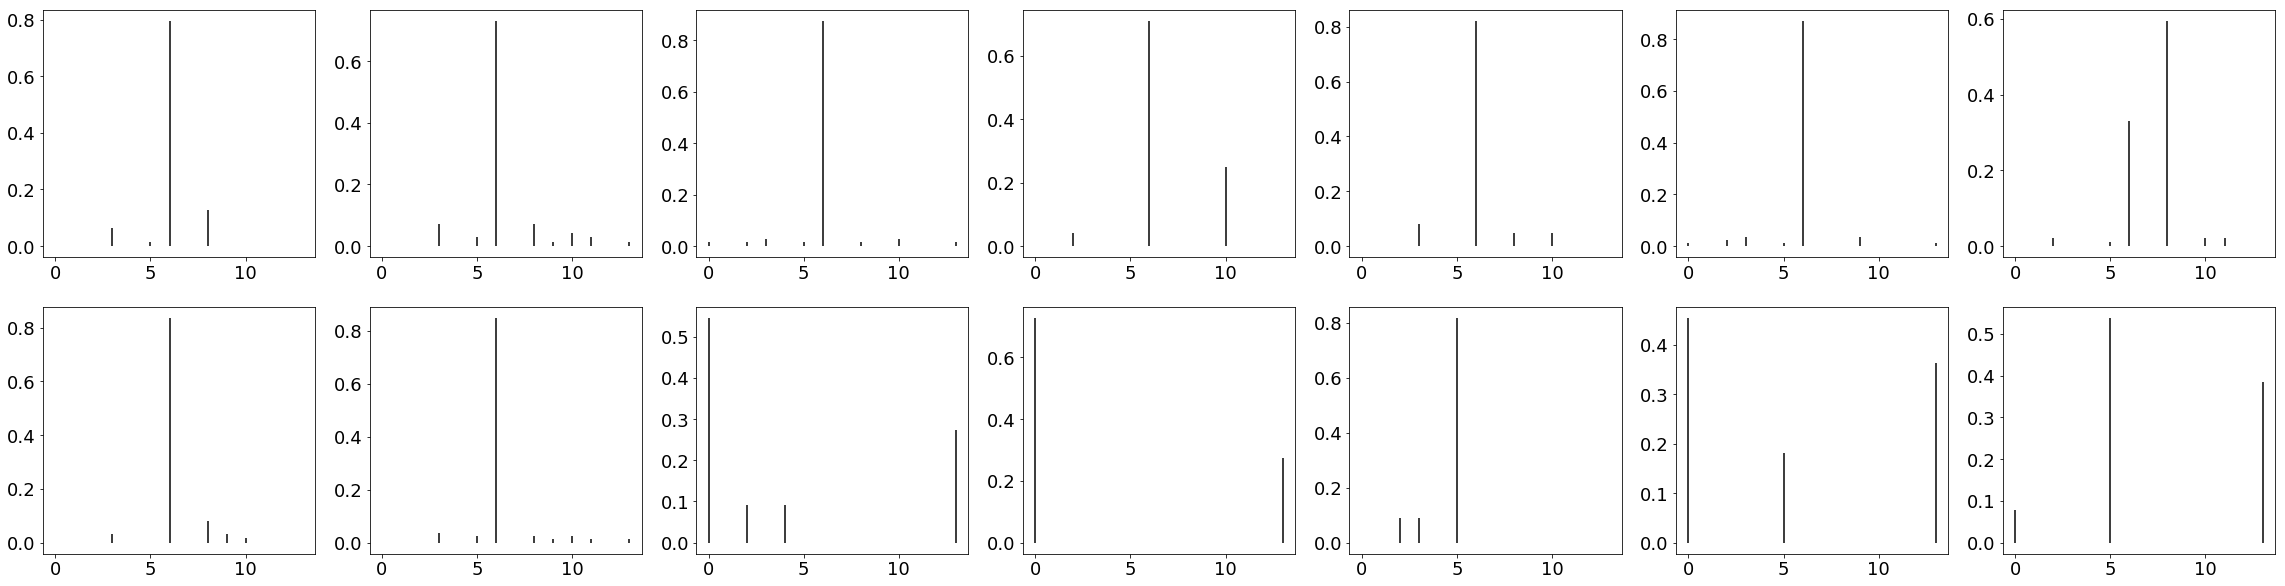

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  2  1  0  0  0  0  0  0  2  0  0]
 [ 0  0  5  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  1  0  0  0  0  0  0  1  0  0  2]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0 16  1  0  1  2  0  0]
 [ 0  0  0  0  1  0  0  0  2  0  1  2  0  0]
 [ 0  0  0  0  0  0  0  1  0 19  0  0  0  0]
 [ 0  0  0  0  1  0  0  1  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  4 15  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  1  1  0 16]]


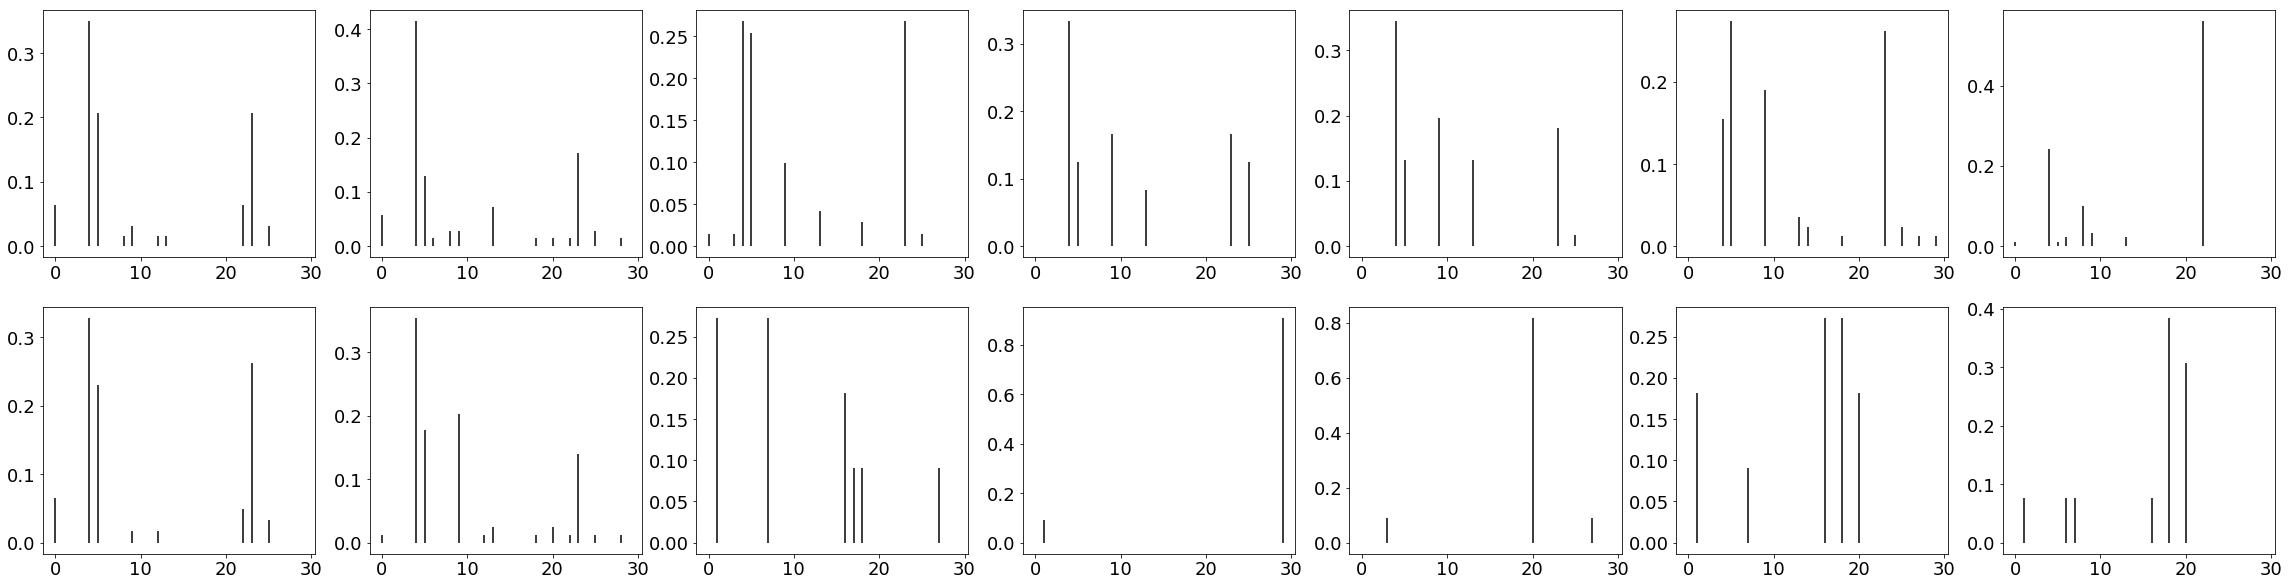

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  1  0  0  0  0  0  0  1  2  0  1]
 [ 0  0  6  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  4  0  5  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 16  0  0  1  3  0  0]
 [ 0  0  0  0  0  0  0  2  2  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  0  0 13  5  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  3 17  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  0  1  0  0  0  1  0 15]]


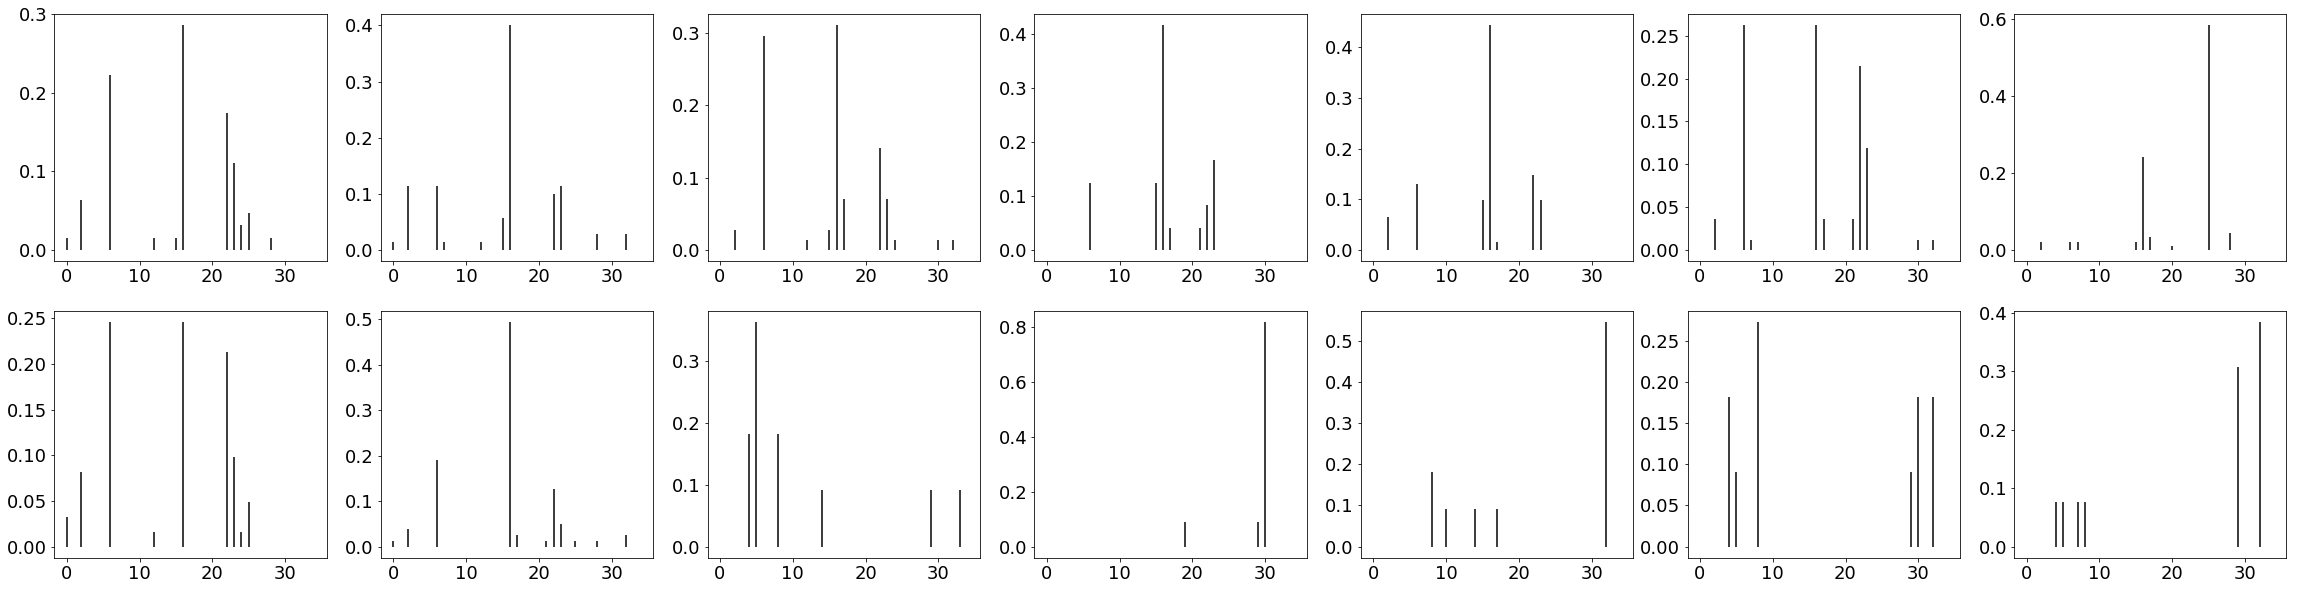

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  2  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  6  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0 15  0  1  0  3  0  0]
 [ 0  1  0  0  0  0  0  4  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2 15  2  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  3 16  0  0]
 [ 0  0  1  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  1  0 18]]


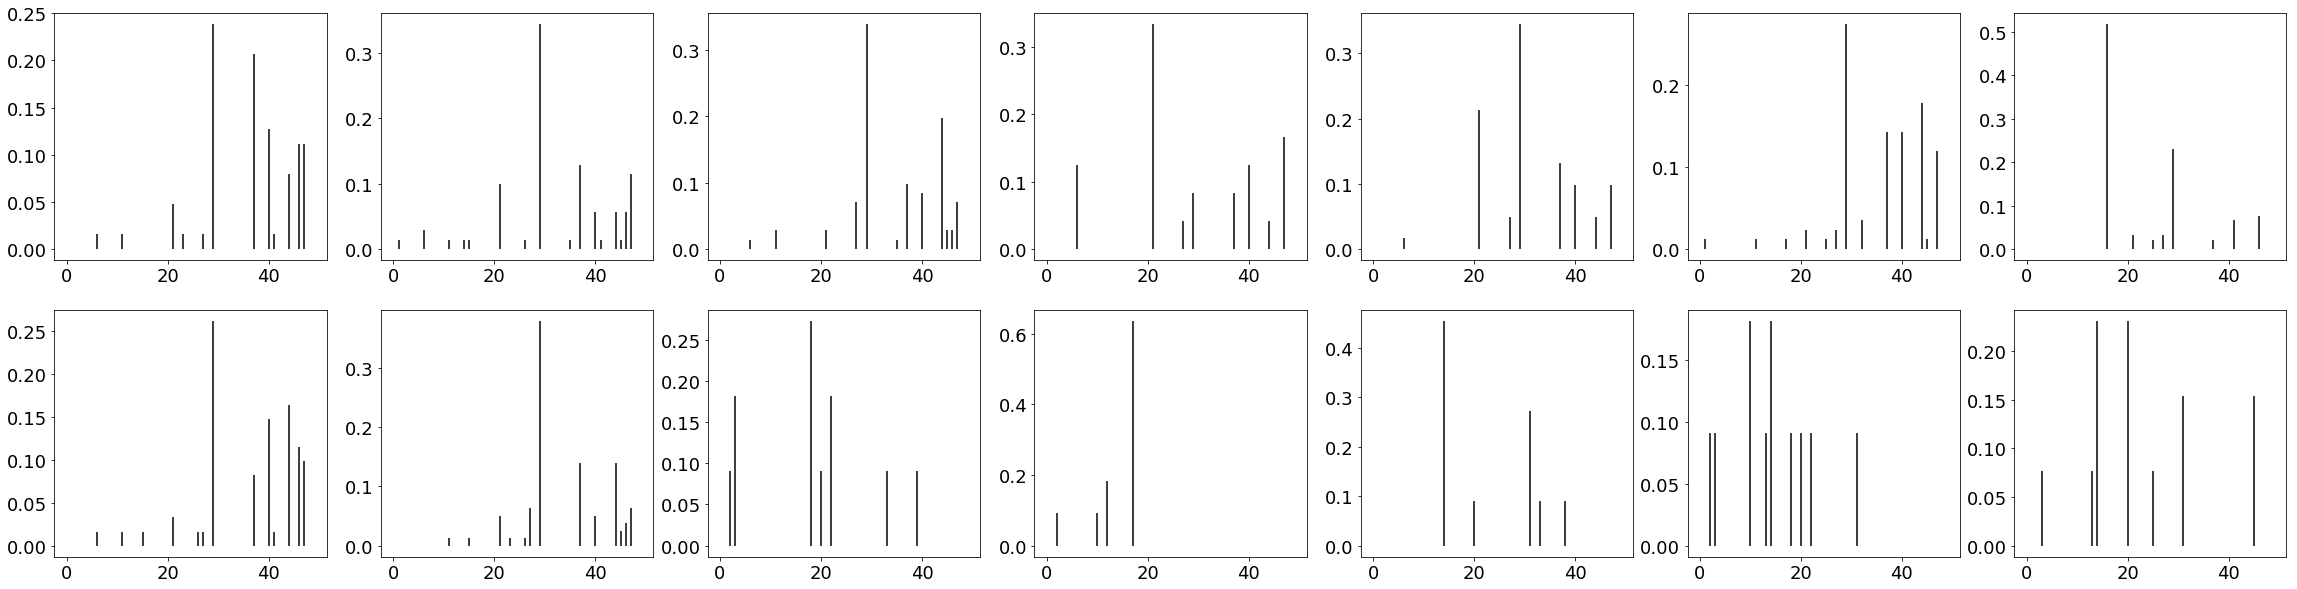

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  4  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  2  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0 19  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0 12  1  1  1  3  0  0]
 [ 0  0  0  0  0  0  0  0  4  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 14  5  0  0]
 [ 0  0  0  0  0  0  0  2  0  1  5 13  0  0]
 [ 0  0  0  0  1  0  0  0  0  1  0  0  1  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  2  0 16]]


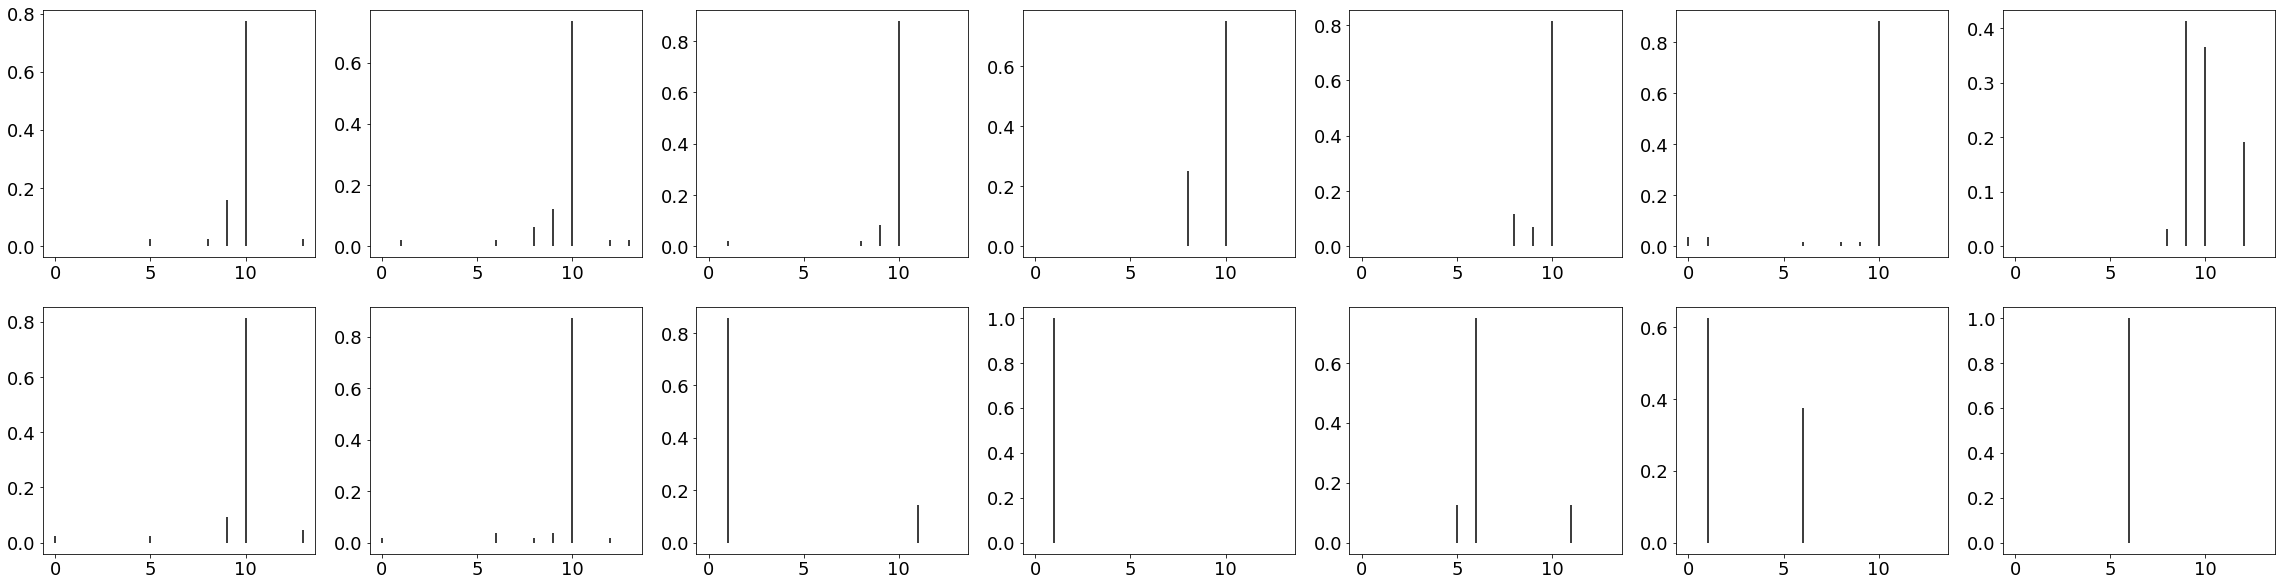

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  1  0  0  0  1  0  0  1  0  0]
 [ 0  0  3  0  3  0  0  0  0  0  0  0  1  0]
 [ 0  7  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  1  4  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  3  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  1 16  2  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  6 14  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  1  0  0  0  0  0  0  0  1  0 15]]


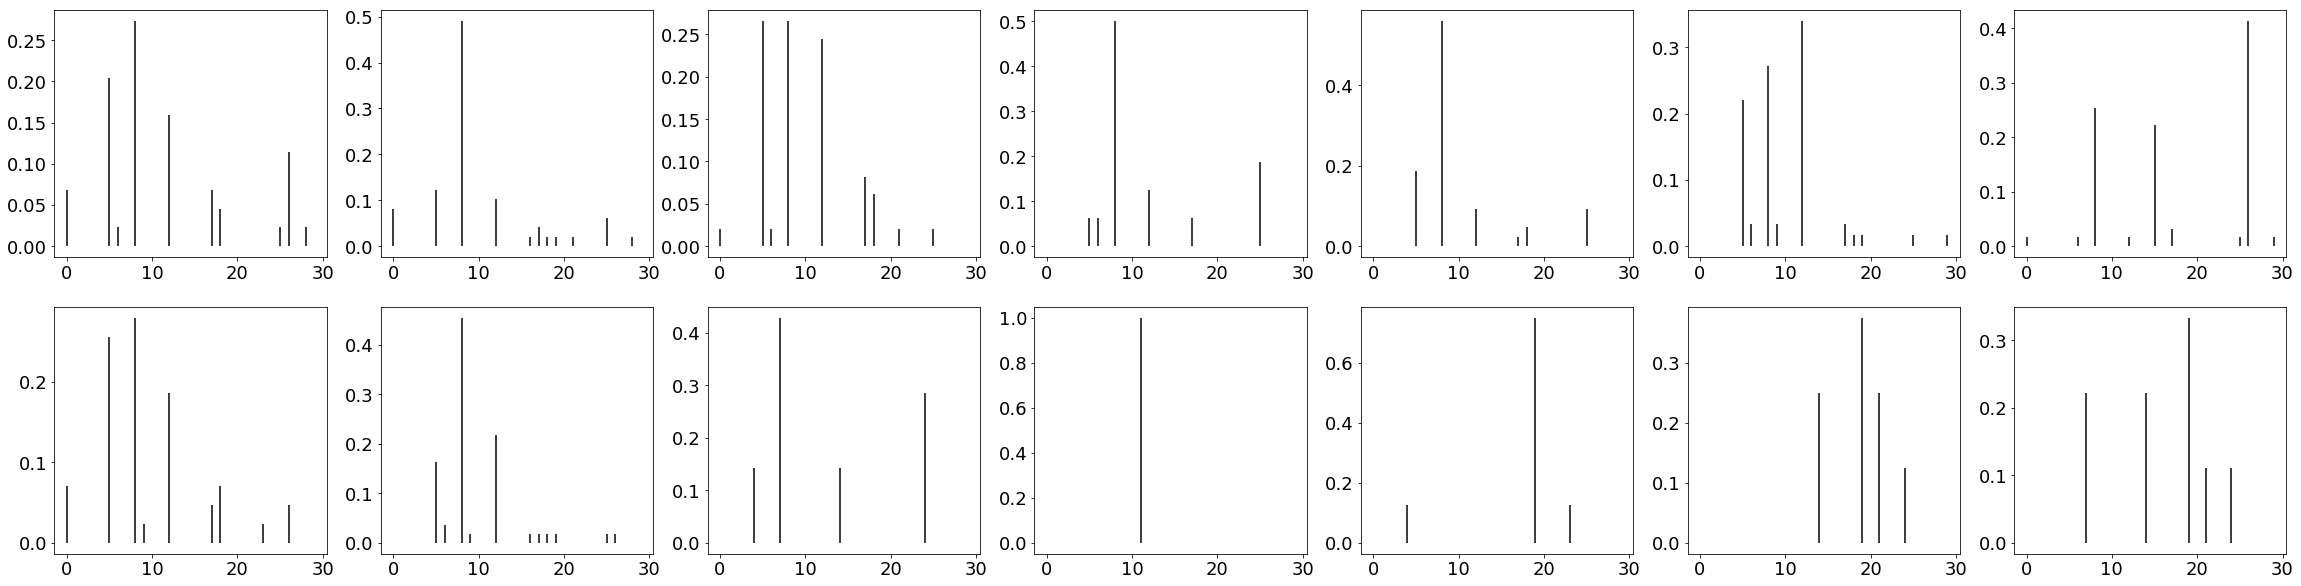

[[ 2  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0 16  0  1  1  0  0  0  1  0  0  1  0  1]
 [ 0  0  5  0  1  0  0  1  0  0  0  0  0  0]
 [ 0  4  0  5  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 15  1  0  1  3  0  0]
 [ 0  1  0  0  0  0  0  2  0  0  2  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  4  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  4 16  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  2  0]
 [ 0  3  0  1  0  0  0  0  0  0  1  0  0 15]]


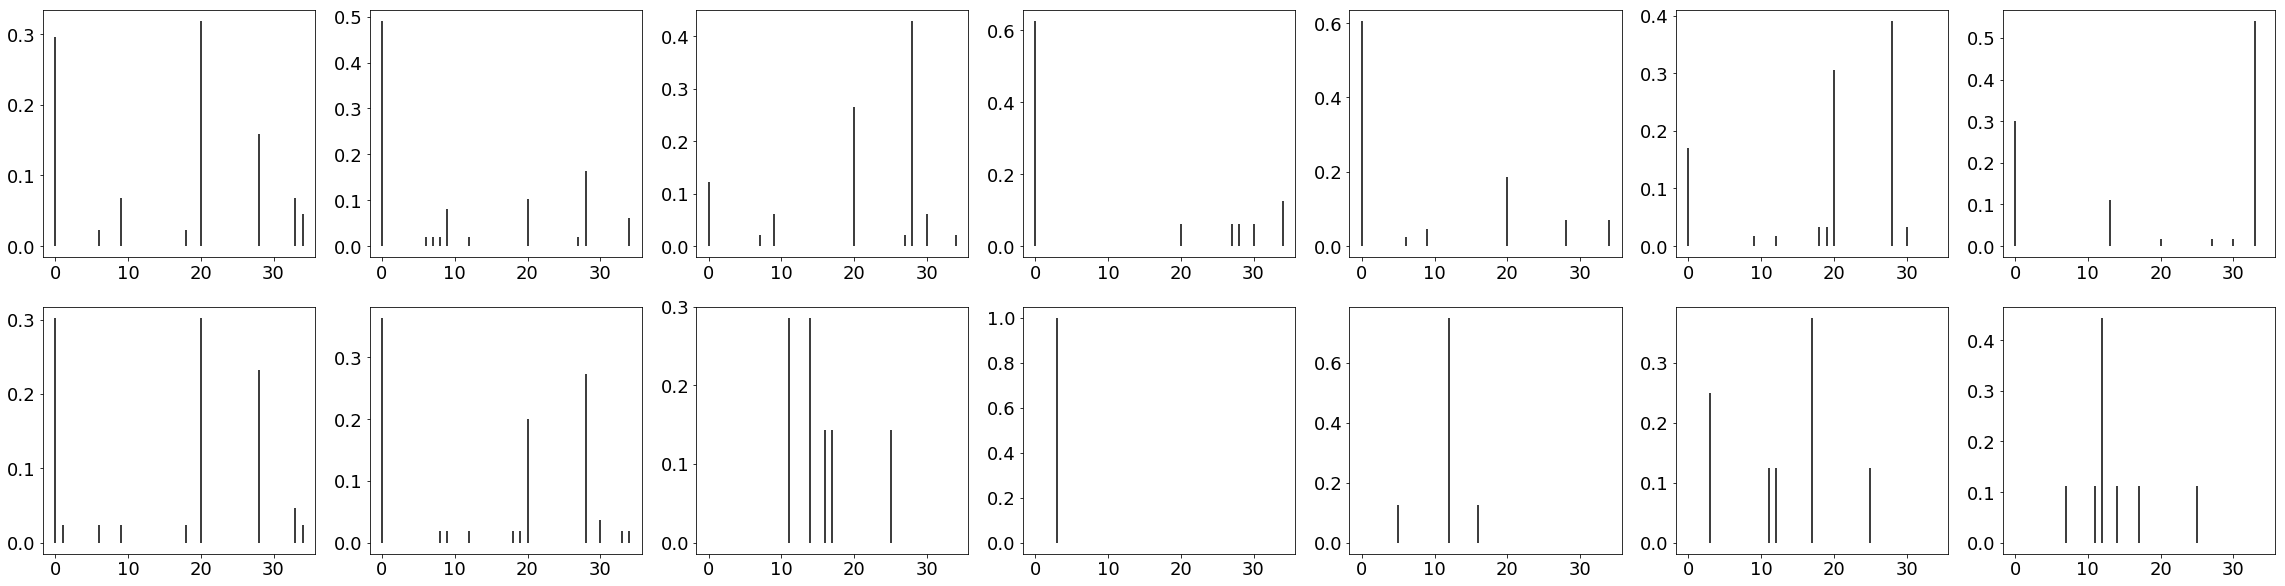

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  1  0  0  0  0  0  1  0  3  0  3]
 [ 0  0  5  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0 16  0  1  0  3  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  2  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0 13  5  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0 20  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  1  0 17]]


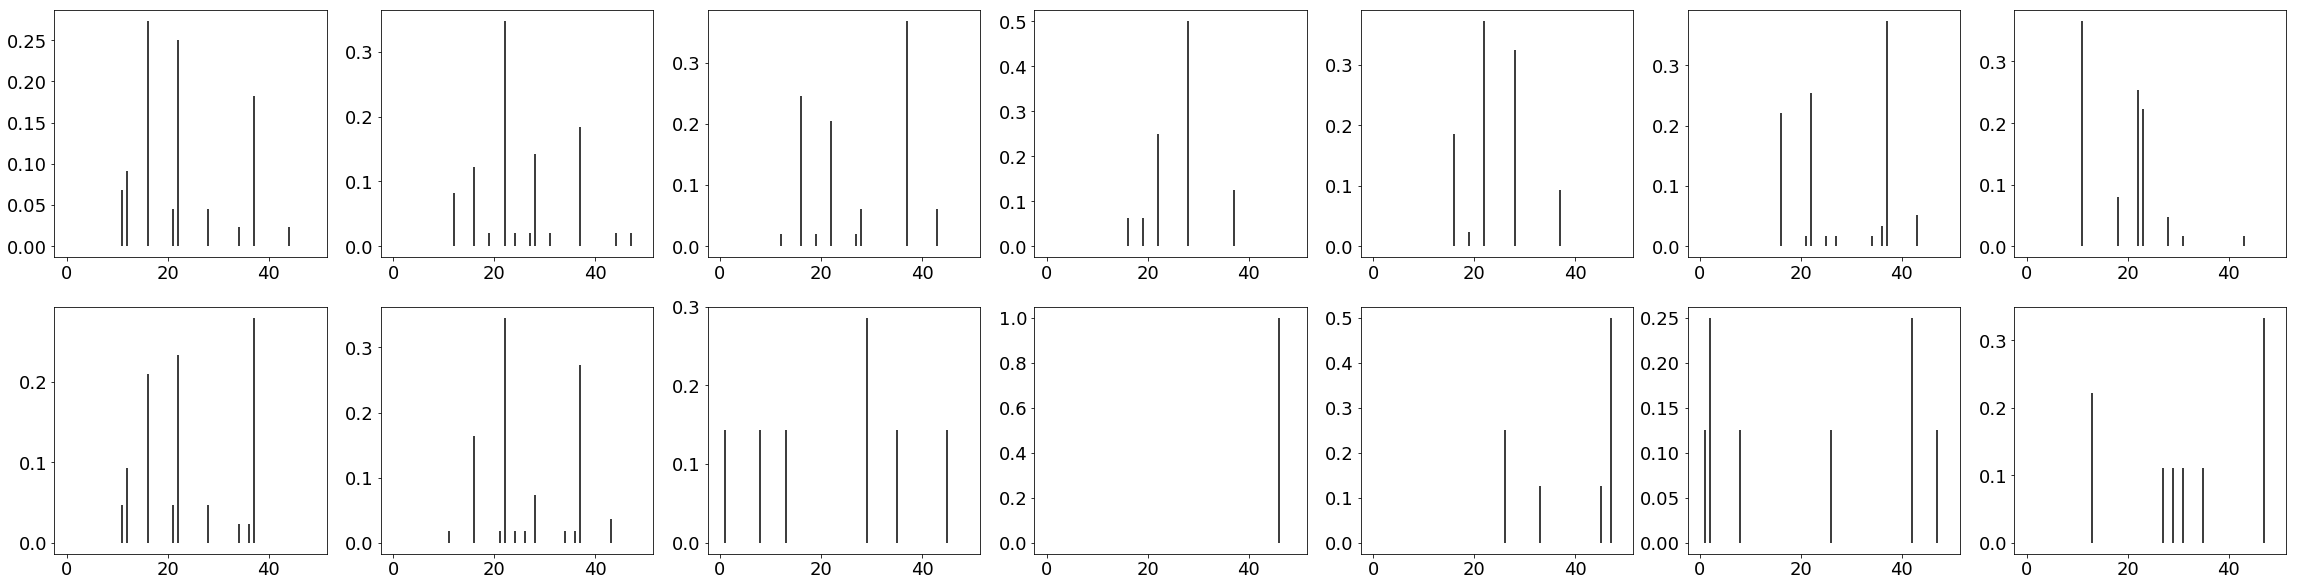

,Segment_length,Overlap (0-X%),K-value,Classifier,Accuracy
0,5,0%,14,Decision Tree,0.809248554913
1,5,0%,30,Decision Tree,0.861271676301
2,5,0%,35,Decision Tree,0.838150289017
3,5,0%,50,Decision Tree,0.809248554913
4,20,0%,14,Decision Tree,0.71098265896
5,20,0%,30,Decision Tree,0.78612716763
6,20,0%,35,Decision Tree,0.751445086705
7,20,0%,50,Decision Tree,0.768786127168
8,35,0%,14,Decision Tree,0.774566473988
9,35,0%,30,Decision Tree,0.768786127168


In [56]:
train_set = (train_raw, train_label) 
test_set = (test_raw, test_label)
seg_set, cluster_set = [5, 20, 35, 50], [14, 30, 35, 50]
display_table(train_set, test_set, seg_set, cluster_set)

In [ ]:
import heapq 
max_heap = []
with open("Output.txt", "w") as text_file:
    for i in range(1, 9):
        for j in range (1, 9):
            sl_temp = i*5 #5,10,15,20,25,30,35,40
            cs_temp = j*50 #50,100,150,200,250,300,350,400
            error_rate_temp, confusion_mt_temp = runForest(groupdata_train_raw, groupdata_train_label,groupdata_test_raw ,
groupdata_test_label, sl_temp, cs_temp)
            print("seg_length = {sl}, cluster_size = {cs}, error_rate = {er}".format(sl = sl_temp, cs = cs_temp, er = error_rate_temp), file=text_file)
            
            # find 10 minimum values
            neg_er = -error_rate_temp
            if len(max_heap) < 10:
                heapq.heappush(max_heap, (neg_er, sl_temp, cs_temp))
            else:
                if neg_er > max_heap[0][0]:
                    heapq.heappop(max_heap)
                    heapq.heappush(max_heap, (neg_er, sl_temp, cs_temp))
    
    # summary
    print(" ")
    print("----- 10 minimum error_rate in reversed order with negative values-----", file = text_file)
    print("order: error_rate, seg_length, cluster_size", file = text_file)
    for k in range(0, 10):
        print(max_heap[k], file=text_file)

In [61]:
k

actual,Brush_teeth,Climb_stairs,Comb_hair,Descend_stairs,Drink_glass,Eat_meat,Eat_soup,Getup_bed,Liedown_bed,Pour_water,Sitdown_chair,Standup_chair,Use_telephone,Walk
prediction,,,,,,,,,,,,,,
Brush_teeth,3,0,0,0,0,0,0,0,0,0,0,0,0,0
Climb_stairs,0,19,0,1,0,0,0,0,0,0,0,0,0,4
Comb_hair,0,0,6,0,0,0,0,0,0,0,0,0,1,0
Descend_stairs,0,0,0,8,0,0,0,0,0,0,0,0,0,0
Drink_glass,0,1,1,0,20,0,0,0,0,0,0,0,1,0
Eat_meat,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Getup_bed,0,0,0,0,0,0,0,20,5,1,0,1,0,0
Pour_water,0,0,0,0,0,0,1,0,0,19,1,0,0,0
Sitdown_chair,0,0,0,0,0,0,0,1,1,0,18,5,0,0
